C:\Users\Cristiano\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Cristiano\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Cristiano\AppData\Local\Temp\ipykernel_17056\2807252497.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

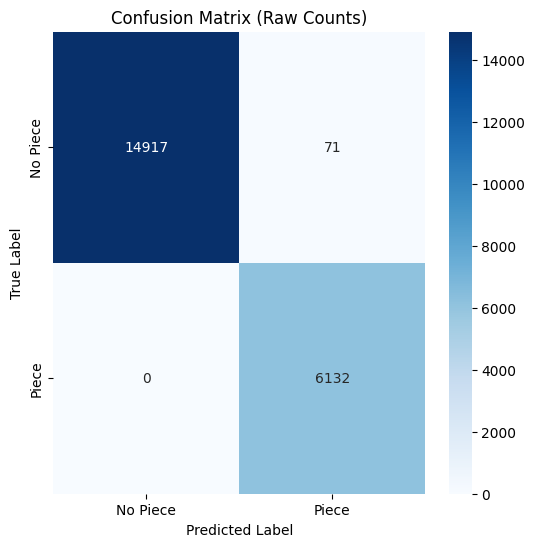

Piece count MSE: 0.3000
Piece count RMSE: 0.5477

Examples of correct predictions:
Number of correct predictions: 5


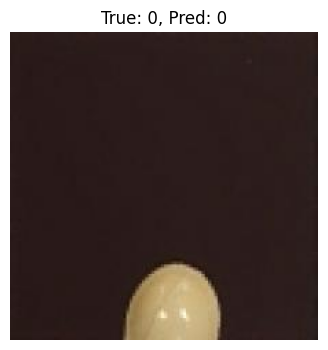

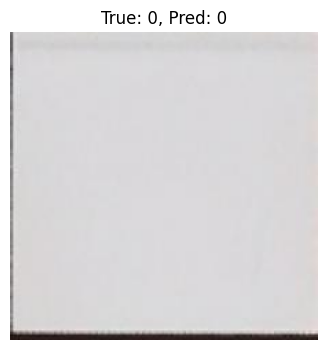

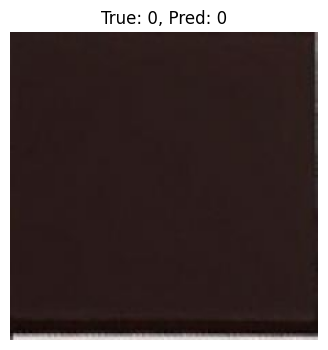

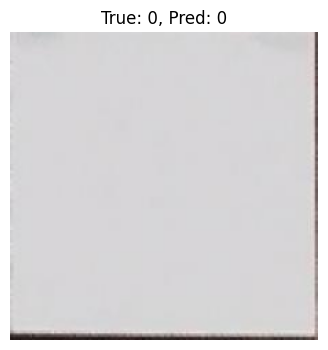

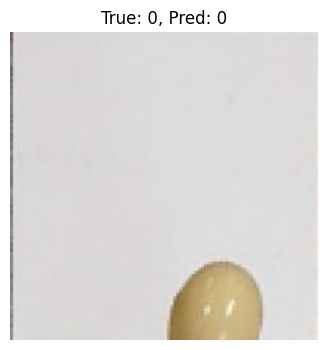


Examples of incorrect predictions:
Number of incorrect predictions: 5


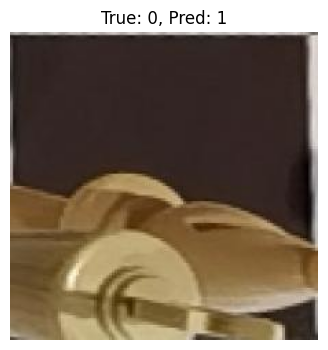

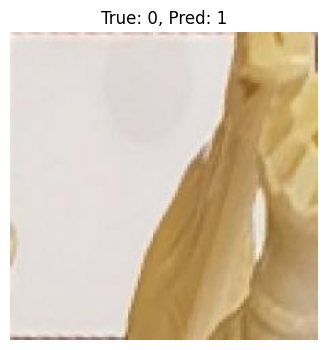

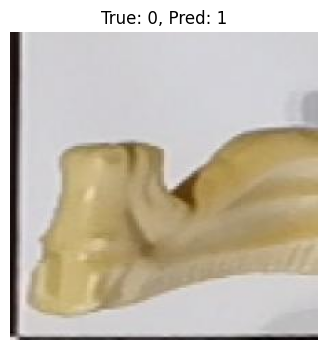

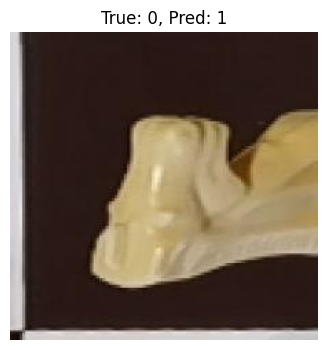

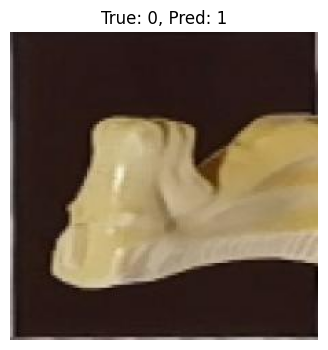

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch import nn
from PIL import Image
import os
from pathlib import Path

# Load the model from the saved state dict
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to evaluate the model, plot the confusion matrix, and show MSE piece count
def evaluate_and_plot(model, val_loader, device):
    all_labels = []
    all_preds = []
    correct = []
    incorrect = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            predictions = (probs > 0.5).cpu().numpy().astype(int)
            labels_cpu = labels.cpu().numpy().astype(int)

            all_labels.extend(labels_cpu)
            all_preds.extend(predictions)

            for i in range(len(labels)):
                image_path = val_loader.dataset.imgs[batch_idx * val_loader.batch_size + i][0]
                label_cpu = labels_cpu[i][0]
                pred_cpu = predictions[i][0]
                if pred_cpu == label_cpu:
                    correct.append((image_path, label_cpu, pred_cpu))
                else:
                    incorrect.append((image_path, label_cpu, pred_cpu))

    # Compute confusion matrix with raw counts
    cm = confusion_matrix(np.array(all_labels), np.array(all_preds))

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Piece', 'Piece'], yticklabels=['No Piece', 'Piece'])
    plt.title('Confusion Matrix (Raw Counts)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate piece counts per image
    from collections import defaultdict
    pred_counts = defaultdict(int)
    true_counts = defaultdict(int)

    # Use filenames to group predictions by image
    for i in range(len(all_labels)):
        # Extract board id or unique image id from filenames or recreate a key
        # Here I assume filenames in val_loader.dataset.imgs and they are aligned with all_labels
        image_path = val_loader.dataset.imgs[i][0]
        board_id = "_".join(Path(image_path).name.split("_")[:2])  # example key format
        true_counts[board_id] += all_labels[i][0]
        pred_counts[board_id] += all_preds[i][0]

    true_counts_list = list(true_counts.values())
    pred_counts_list = list(pred_counts.values())

    # Calculate MSE and RMSE for piece count per image
    mse = mean_squared_error(true_counts_list, pred_counts_list)
    rmse = np.sqrt(mse)

    print(f"Piece count MSE: {mse:.4f}")
    print(f"Piece count RMSE: {rmse:.4f}")

    show_examples(correct, incorrect)
# Function to show correct and incorrect examples
def show_examples(correct, incorrect, num_examples=5):
    print("\nExamples of correct predictions:")
    num_correct = min(num_examples, len(correct))
    print("Number of correct predictions:", num_correct)
    if num_correct == 0:
        print("No correct predictions to show.")
    for i in range(num_correct):
        image_path, true_label, predicted_label = correct[i]
        img = Image.open(image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')
        plt.show()

    print("\nExamples of incorrect predictions:")
    num_incorrect = min(num_examples, len(incorrect))
    print("Number of incorrect predictions:", num_incorrect)
    if num_incorrect == 0:
        print("No incorrect predictions to show.")
    for i in range(num_incorrect):
        image_path, true_label, predicted_label = incorrect[i]
        img = Image.open(image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"True: {int(true_label)}, Pred: {int(predicted_label)}")
        plt.axis('off')
        plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # ResNet50 model setup
# model = models.resnet50(weights=False)
# model.fc = nn.Linear(model.fc.in_features, 1)  # Adjust for your binary classification task
# model = load_model(model, './checkpoints_resnet50_1_squares/best_piece_classifier.pt')  # Load your saved model

# MobileNet V3 Large model setup
# model = models.mobilenet_v3_large(weights=False)
# num_features = model.classifier[3].in_features
# model.classifier[3] = nn.Linear(num_features, 1)
# model = load_model(model, './checkpoints_mobileNetV3_squares/best_piece_classifier.pt')
# model = model.to(device)

# SqueezeNet model setup
model = models.squeezenet1_0(pretrained=False)
model.classifier[1] = nn.Conv2d(512, 1, kernel_size=1)
model.num_classes = 1

class SqueezeNetBinary(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model

    def forward(self, x):
        x = self.base(x)
        return x.view(x.size(0), -1)  # Flatten to shape [batch_size, 1]

model = SqueezeNetBinary(model)
model = load_model(model, './checkpoints_SqueezeNet_1.0_squares/best_piece_classifier.pt')
model = model.to(device)



# Prepare your validation dataset and dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

evaluation_dataset = datasets.ImageFolder('split_by_presence/val', transform=transform)
evaluation_loader = DataLoader(evaluation_dataset, batch_size=128, shuffle=False)

# Now call the function to evaluate and plot the confusion matrix
evaluate_and_plot(model, evaluation_loader, device)